# Preprocess the PAPILA dataset

The data is linked in the paper https://www.nature.com/articles/s41597-022-01388-1#code-availability . First download and extract it.

We now create the splits we use in our paper.

In [1]:
import numpy as np
import pandas as pd

# helper functions that come with the dataset

def _fix_df(df):
    df_new = df.drop(['ID'], axis=0)
    df_new.columns = df_new.iloc[0,:]
    df_new.drop([np.nan], axis=0, inplace=True)
    df_new.columns.name = 'ID'
    return df_new


def read_clinical_data(abs_path='../'):
    df_od = pd.read_excel(abs_path + 'ClinicalData/patient_data_od.xlsx', index_col=[0])
    df_os = pd.read_excel(abs_path + 'ClinicalData/patient_data_os.xlsx', index_col=[0])
    return _fix_df(df=df_od), _fix_df(df=df_os)


In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "/mnt/papila/"
SPLIT_DIR = "../splits/papila/" # where we will save the splits

os.makedirs(SPLIT_DIR, exist_ok=True)
df_od, df_os = read_clinical_data(abs_path=DATA_DIR)

df_od.head()

ID,Age,Gender,Diagnosis,dioptre_1,dioptre_2,astigmatism,Phakic/Pseudophakic,Pneumatic,Perkins,Pachymetry,Axial_Length,VF_MD
#002,47,0,2,0.75,-1.75,90,0,21,NaN,586,23.64,-0.07
#004,58,1,1,1.5,-1.75,85,0,NaN,19,501,23.06,-3.26
#005,89,1,1,-0.75,-1.25,101,1,13,14,565,23.81,-14.98
#006,69,0,2,1,-1.5,95,0,22,NaN,612,26.25,-2.07
#007,22,1,2,-0.25,0,0,0,14,NaN,NaN,23.39,-2.3


In [3]:
np.random.seed(42)

# we split along patient ids because we must 
# use the same split for OD and OS
ids = df_od.index.values.copy()

# split patients 70/10/20
np.random.shuffle(ids)
train_ids = ids[:int(len(ids)*0.7)]
val_ids = ids[int(len(ids)*0.7):int(len(ids)*0.8)]
test_ids = ids[int(len(ids)*0.8):]

# create splits, for both datasets with same patients in each split
df_od_train = df_od.loc[train_ids]
df_od_val = df_od.loc[val_ids]
df_od_test = df_od.loc[test_ids]

df_os_train = df_os.loc[train_ids]
df_os_val = df_os.loc[val_ids]
df_os_test = df_os.loc[test_ids]

# create column with split assignment
df_od_train['split'] = 'train'
df_od_val['split'] = 'val'
df_od_test['split'] = 'test'

df_os_train['split'] = 'train'
df_os_val['split'] = 'val'
df_os_test['split'] = 'test'

# ensure that ids are the same in both datasets
assert np.all(df_od_train.index.values == df_os_train.index.values)
assert np.all(df_od_val.index.values == df_os_val.index.values)
assert np.all(df_od_test.index.values == df_os_test.index.values)

# merge train, val, test splits into one dataframe for convenience
df_od_total = pd.concat([df_od_train, df_od_val, df_od_test])
df_os_total = pd.concat([df_os_train, df_os_val, df_os_test])

# sanity check that age and gender are same for both eyes
assert np.all(df_od_total['Age'] == df_os_total['Age'])

# concatenate OD and OS dataframes, appending os or os to id
df_od_total["eye"] = ["OD" for _ in range(len(df_od_total))]
df_os_total["eye"] = ["OS" for _ in range(len(df_os_total))]
df = pd.concat([df_od_total, df_os_total], axis=0)

# remove hashtag from id
df.index = df.index.str.replace("#", "")

# get number of images in each split
print(df['split'].value_counts())

df["Path"] = "FundusImages/RET" + df.index.values +  df["eye"] + ".jpg"

# we create this intermediate column to keep the cell below idempotent
# i.e. so we can run it multiple times without messing it up
df["age_old"] = df["Age"]
df


train    340
test      98
val       50
Name: split, dtype: int64


ID,Age,Gender,Diagnosis,dioptre_1,dioptre_2,astigmatism,Phakic/Pseudophakic,Pneumatic,Perkins,Pachymetry,Axial_Length,VF_MD,split,eye,Path,age_old
031,29,1,0,-1.75,-1,95,1,15,NaN,545,23.94,NaN,train,OD,FundusImages/RET031OD.jpg,29
009,79,0,2,0.75,-1.5,95,0,23,20,511,NaN,-3.69,train,OD,FundusImages/RET009OD.jpg,79
198,67,0,0,0.5,-0.75,156,1,14,NaN,486,25.37,NaN,train,OD,FundusImages/RET198OD.jpg,67
258,54,1,0,1.5,-0.75,6,1,14,NaN,491,22.4,NaN,train,OD,FundusImages/RET258OD.jpg,54
244,60,1,0,NaN,-0.75,25,0,15,NaN,479,23.51,NaN,train,OD,FundusImages/RET244OD.jpg,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,66,1,0,0,-0.75,118,1,16,NaN,593,21.4,NaN,test,OS,FundusImages/RET146OS.jpg,66
020,87,1,1,0.5,-0.5,110,1,NaN,15,NaN,23.02,-4.74,test,OS,FundusImages/RET020OS.jpg,87
131,63,1,0,1.5,-0.5,80,1,23,NaN,620,22.29,NaN,test,OS,FundusImages/RET131OS.jpg,63
224,56,1,0,0.75,-1,85,0,17,NaN,570,23.05,NaN,test,OS,FundusImages/RET224OS.jpg,56


In [4]:
# create Sex column for consistency with other datasets
# 0 -> male, 1 -> female
df["Sex"] = df["Gender"].astype(int)

# create Age column 0 -> <60 , 1 -> >=60
df["Age"] = (df["age_old"] >= 60).astype(int)

# drop rows with disease label 2
df = df[df["Diagnosis"] != 2]
# disease label: 0 -> healthy, 1 -> glaucoma
df["binaryLabel"] = df["Diagnosis"].astype(int)

df

/tmp/ipykernel_795718/722048526.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["binaryLabel"] = df["Diagnosis"].astype(int)


ID,Age,Gender,Diagnosis,dioptre_1,dioptre_2,astigmatism,Phakic/Pseudophakic,Pneumatic,Perkins,Pachymetry,Axial_Length,VF_MD,split,eye,Path,age_old,Sex,binaryLabel
031,0,1,0,-1.75,-1,95,1,15,NaN,545,23.94,NaN,train,OD,FundusImages/RET031OD.jpg,29,1,0
198,1,0,0,0.5,-0.75,156,1,14,NaN,486,25.37,NaN,train,OD,FundusImages/RET198OD.jpg,67,0,0
258,0,1,0,1.5,-0.75,6,1,14,NaN,491,22.4,NaN,train,OD,FundusImages/RET258OD.jpg,54,1,0
244,1,1,0,NaN,-0.75,25,0,15,NaN,479,23.51,NaN,train,OD,FundusImages/RET244OD.jpg,60,1,0
221,0,1,0,NaN,-0.5,165,1,13,NaN,472,24.35,NaN,train,OD,FundusImages/RET221OD.jpg,56,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,1,1,0,0,-0.75,118,1,16,NaN,593,21.4,NaN,test,OS,FundusImages/RET146OS.jpg,66,1,0
020,1,1,1,0.5,-0.5,110,1,NaN,15,NaN,23.02,-4.74,test,OS,FundusImages/RET020OS.jpg,87,1,1
131,1,1,0,1.5,-0.5,80,1,23,NaN,620,22.29,NaN,test,OS,FundusImages/RET131OS.jpg,63,1,0
224,0,1,0,0.75,-1,85,0,17,NaN,570,23.05,NaN,test,OS,FundusImages/RET224OS.jpg,56,1,0


In [5]:
df_train = df[df["split"] == "train"]
df_val = df[df["split"] == "val"]
df_test = df[df["split"] == "test"]

df_train.to_csv(SPLIT_DIR + "train.csv", index=False)
df_val.to_csv(SPLIT_DIR + "val.csv", index=False)
df_test.to_csv(SPLIT_DIR + "test.csv", index=False)


## Splits are done, now visualise the data and get some summary statistics

sanity check
Image shape: (1934, 2576, 3), Image type: uint8, Image range: 0 - 158, Age: 0, Sex: 1


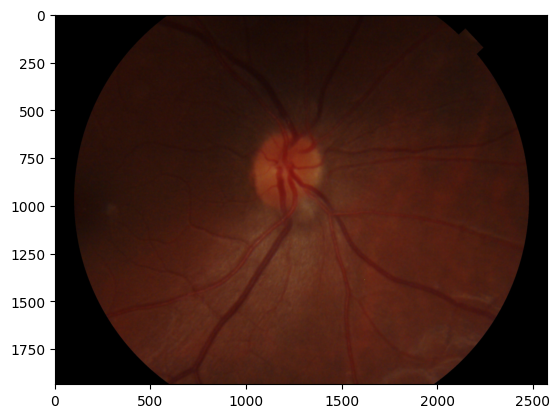

In [6]:
print("sanity check")
img = plt.imread(os.path.join(DATA_DIR, df["Path"].values[0]))  # type: ignore
print(
    f"Image shape: {img.shape}, Image type: {img.dtype}, Image range: {img.min()} -"
    f" {img.max()}, Age: {df['Age'].values[0]}, Sex:"
    f" {df['Sex'].values[0]}"
)
plt.imshow(img)

In [7]:
num_images = df.shape[0]
print(f"Number of images: {num_images}")

num_patients = len(df.index.unique())
print(f"Number of patients: {num_patients}")

num_male = len(df[df["Sex"] == 0])
print(f"Number of Males: {num_male}")

num_female = len(df[df["Sex"] == 1])
print(f"Number of Females: {num_female}")

assert num_male + num_female == num_images

num_under_60 = len(df[df["Age"] == 0])
print(f"Number of Under 60: {num_under_60}")

num_over_60 = len(df[df["Age"] == 1])
print(f"Number of Over 60: {num_over_60}")

assert num_under_60 + num_over_60 == num_images

num_benign = len(df[df["binaryLabel"] == 0])
print(f"Number of no finding: {num_benign}")

num_malignant = len(df[df["binaryLabel"] == 1])
print(f"Number of glaucoma: {num_malignant}")

assert num_benign + num_malignant == num_images

Number of images: 420
Number of patients: 210
Number of Males: 146
Number of Females: 274
Number of Under 60: 170
Number of Over 60: 250
Number of no finding: 333
Number of glaucoma: 87


In [30]:
print(f"percentage of male images: {num_male / num_images * 100}")
print(f"percentage of female images: {num_female / num_images * 100}")

num_male_positive_label = len(df[(df["binaryLabel"] == 1) & (df["Sex"] == 0)])
num_male_negative_label = len(df[(df["binaryLabel"] == 0) & (df["Sex"] == 0)])
assert num_male_positive_label + num_male_negative_label == num_male

print(f"prevalence of positive class in male: {num_male_positive_label / num_male * 100}")

num_female_positive_label =  len(df[(df["binaryLabel"] == 1) & (df["Sex"] == 1)])
print(f"prevalence of positive class in female: {num_female_positive_label / num_female * 100}")


print(f"percentage of under 60 images: {num_under_60 / num_images * 100}")
print(f"percentage of over 60 images: {num_over_60 / num_images * 100}")

num_under_60_positive_label =  len(df[(df["binaryLabel"] == 1) & (df["Age"] == 0)])
num_under_60_negative_label =  len(df[(df["binaryLabel"] == 0) & (df["Age"] == 0)])
assert num_under_60_positive_label + num_under_60_negative_label == num_under_60

print(f"prevalence of positive class in under 60: {num_under_60_positive_label / num_under_60 * 100}")

num_over_60_positive_label = len(df[(df["binaryLabel"] == 1) & (df["Age"] == 1)])
print(f"prevalence of positive class in over 60: {num_over_60_positive_label / num_over_60 * 100}")


percentage of male images: 34.76190476190476
percentage of female images: 65.23809523809524
prevalence of positive class in male: 23.972602739726025
prevalence of positive class in female: 18.97810218978102
percentage of under 60 images: 40.476190476190474
percentage of over 60 images: 59.523809523809526
prevalence of positive class in under 60: 6.470588235294119
prevalence of positive class in over 60: 30.4
